In [1]:
import sys
import os
import pandas as pd
import datetime as datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import OneHotEncoder
import matplotlib
import matplotlib.pyplot as plt
#import psycopg2
from scipy.stats import ks_2samp
import scipy.stats as scats
# import visuals as vs
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from heapq import nlargest
plt.style.use('ggplot') 
%matplotlib inline

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer


from icu_mortality_prediction import DATA_DIR

# MIMIC-III Critical Care Database

MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (both in and out of hospital).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors:

it is freely available to researchers worldwide
it encompasses a diverse and very large population of ICU patients
it contains high temporal resolution data including lab results, electronic documentation, and bedside monitor trends and waveforms.

Citations: 
MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016). DOI: 10.1038/sdata.2016.35. Available at: http://www.nature.com/articles/sdata201635

Pollard, T. J. & Johnson, A. E. W. The MIMIC-III Clinical Database http://dx.doi.org/10.13026/C2XW26 (2016).



# IMPORTING LAB DATA
The mimic III database was downloaded and reconstructed locally using posgresql. The database was managed graphically using Portico. 
A query was run on the mimic III database to generate chart data for the first 24hrs of a patients icu stay as well as demographic data for patients diagnosed with sepsis according to the Angus criteria. 
(Angus et al, 2001. Epidemiology of severe sepsis in the United States; http://www.ncbi.nlm.nih.gov/pubmed/11445675 )

The query was exported from Porticoto the file LAB_EVENTS_ANGUS_FIRST24.csv. The data was read into a pandas dataframe lab_events. 


In [2]:
lab_events_filename = 'LAB_EVENTS_FIRST24.csv'
lab_events_filepath = os.path.join(DATA_DIR, 'interim',lab_events_filename)
lab_events_data_df = pd.read_csv(lab_events_filepath) #, index_col = 'icustay_id')

lab_events_data_df.loc[:,'charttime']  = pd.to_datetime(lab_events_data_df.loc[:,'charttime'])
lab_events_data_df = lab_events_data_df.sort_values(['icustay_id', 'charttime'],ascending=True)
# lab_events_data_df.drop(['charttime'], axis=1, inplace=True)
lab_events_data_df.head()

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0


### DEBUG START

In [3]:
test_df = lab_events_data_df.copy()

In [36]:
test_pivot_df = test_df.pivot(
#             index=test_df.index, 
            columns='label', 
            values=['valuenum']
)

In [42]:
test_pivot_df.columns.levels[1]

Index(['24 hr Creatinine', 'Creatinine', 'Creatinine, Urine', 'Glucose',
       'Hematocrit', 'Lactate', 'Lactate Dehydrogenase (LD)',
       'Oxygen Saturation', 'Urine Creatinine', 'WBC Count',
       'White Blood Cells', 'pH'],
      dtype='object', name='label')

In [43]:
test_pivot_df.columns = test_pivot_df.columns.levels[1]

In [44]:
selected_test_cols_df = test_df[['hospital_expire_flag', 'subject_id', 'icustay_id', 'gender', 'flag']]

In [45]:
selected_test_cols_df.head()

,hospital_expire_flag,subject_id,icustay_id,gender,flag
714216,0,55973,200001,F,abnormal
714217,0,55973,200001,F,abnormal
714218,0,55973,200001,F,NaN
714219,0,55973,200001,F,NaN
714220,0,55973,200001,F,NaN


In [46]:
test_merged_pivot_df = test_df[['hospital_expire_flag', 'subject_id', 'icustay_id', 'gender', 'flag']].join(
              test_pivot_df, 
#               left_index=True, 
#               right_index=True,
              how='outer'
)

In [47]:
test_merged_pivot_df.head()

,hospital_expire_flag,subject_id,icustay_id,gender,flag,24 hr Creatinine,Creatinine,"Creatinine, Urine",Glucose,Hematocrit,Lactate,Lactate Dehydrogenase (LD),Oxygen Saturation,Urine Creatinine,WBC Count,White Blood Cells,pH
0,0,3,211552,M,abnormal,NaN,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3,211552,M,NaN,NaN,NaN,NaN,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,211552,M,abnormal,NaN,NaN,NaN,NaN,24.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,211552,M,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.3,NaN
4,0,3,211552,M,abnormal,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### DEBUG STOP

## Reorganizing the data
The imported data uses subject_id as the index. The following code moves the subject_id data to a column, creates
a proper index and reorganizes the columns to have the lab results grouped together. 

In [8]:
# print("loading lab data")
# lab_events_data_df['subject_id'] = lab_events_data_df.index
# lab_events_data_df.set_index(np.arange(lab_events_data_df.shape[0]), inplace = True)
# cols = list(lab_events_data_df.columns)
# cols.insert(0, cols.pop(cols.index('icustay_id')))
# cols.insert(1, cols.pop(cols.index('subject_id')))
# lab_events_data_df = lab_events_data_df[cols]
# print("complete")

In [9]:
unique_icu_stay_count = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first').shape[0]
unique_patients_count = lab_events_data_df.drop_duplicates('subject_id', keep = 'first').shape[0]

print("The number of unique ICU stays = {}".format(unique_icu_stay_count))
print("The number of unique patients  = {}\n".format(unique_patients_count))

# display the different measurements captured in the database query
labels = lab_events_data_df.label.unique()
print("Lab measurements inlcude/n")
print(labels)
# display(lab_events_data_df.shape)
print("Example lab values for Lactate:")
display(lab_events_data_df[(lab_events_data_df.label=='Lactate') & (~(lab_events_data_df.valuenum.isnull()))].head())



The number of unique ICU stays = 59798
The number of unique patients  = 45260

Lab measurements inlcude/n
['Hematocrit' 'White Blood Cells' 'pH' 'Lactate' 'Creatinine' 'Glucose'
 'Lactate Dehydrogenase (LD)' 'Oxygen Saturation' 'Creatinine, Urine'
 '24 hr Creatinine' 'Urine Creatinine' 'WBC Count']
Example lab values for Lactate:


,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.4,NaN,0
482496,27513,200003,M,Lactate,2199-08-03 01:55:00,5.1,abnormal,0
482499,27513,200003,M,Lactate,2199-08-03 03:42:00,4.1,abnormal,0
488452,27513,200003,M,Lactate,2199-08-03 17:52:00,2.6,abnormal,0
204004,10950,200006,M,Lactate,2159-09-03 08:11:00,3.1,abnormal,0


## Assessing Feature Prevalence


# DEBUG START 

In [23]:
test_merged_pivot_df.head()

,hospital_expire_flag,subject_id,icustay_id,gender,flag,"(valuenum, 24 hr Creatinine)","(valuenum, Creatinine)","(valuenum, Creatinine, Urine)","(valuenum, Glucose)","(valuenum, Hematocrit)","(valuenum, Lactate)","(valuenum, Lactate Dehydrogenase (LD))","(valuenum, Oxygen Saturation)","(valuenum, Urine Creatinine)","(valuenum, WBC Count)","(valuenum, White Blood Cells)","(valuenum, pH)"
0,0,3,211552,M,abnormal,NaN,3.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,3,211552,M,NaN,NaN,NaN,NaN,91.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,3,211552,M,abnormal,NaN,NaN,NaN,NaN,24.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,3,211552,M,abnormal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.3,NaN
4,0,3,211552,M,abnormal,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
test_merged_pivot_df[~test_merged_pivot_df['Hematocrit'].isna()][['icustay_id','Hematocrit']].groupby('icustay_id').first()


,Hematocrit
icustay_id,
200001,26.1
200003,35.0
200006,24.8
200007,38.1
200009,30.3
...,...
299993,28.9
299994,27.6
299995,42.7


# DEBUG STOP

In [10]:
# REMOVE VARIABLES FOR WHICH THERE IS LITTLE DATA / FEW ICUSTAYS FOR WHICH DATA WAS RECORDED
labels2 = []

for item in labels:
    lab_count = lab_events_data_df['icustay_id'][lab_events_data_df['label'] == item].dropna().unique().shape[0]
    #num_measures = data[data.label == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    print("{}    {}".format(item, lab_count)) #, num_measures)
    if lab_count > 6000:
        print("adding {}".format(item))
        labels2.append(item)
labels2.sort(key=str.lower)
labels2

Hematocrit    59404
adding Hematocrit
White Blood Cells    59175
adding White Blood Cells
pH    45343
adding pH
Lactate    31261
adding Lactate
Creatinine    52902
adding Creatinine
Glucose    51725
adding Glucose
Lactate Dehydrogenase (LD)    14542
adding Lactate Dehydrogenase (LD)
Oxygen Saturation    19243
adding Oxygen Saturation
Creatinine, Urine    6719
adding Creatinine, Urine
24 hr Creatinine    21
Urine Creatinine    4
WBC Count    173


['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

## CALCULATE NUMBER OF SAMPLES FOR EACH FEATURE

In [11]:
labels2[0]

'Creatinine'

In [12]:
# calculating the number of samples taken in 24 hours for each measurement
item = labels2[0]

lab_counts_df =  lab_events_data_df[lab_events_data_df['label'] == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
   
for item in labels2[1:]:
    #num_samps = data['icustay_id'][data.label == item].dropna().unique().shape[0]
    groupby_counts = lab_events_data_df[lab_events_data_df['label'] == item][['icustay_id', 'label']].dropna().groupby('icustay_id').count()
    groupby_counts.columns = [item]
    lab_counts_df = lab_counts_df.merge(groupby_counts,left_index = True, right_index = True, how = 'left', sort = True) 
    #print "{}    {}".format(item, num_measures) #, num_measures)

#num_samps_df.drop('label', axis=1, inplace = True)
lab_counts_df.dropna().head(20)

,label,"Creatinine, Urine",Glucose,Hematocrit,Lactate,Lactate Dehydrogenase (LD),Oxygen Saturation,pH,White Blood Cells
icustay_id,,,,,,,,,
200028,3,1.0,2.0,4.0,8.0,1.0,2.0,16.0,2.0
200075,2,2.0,2.0,2.0,5.0,1.0,3.0,1.0,1.0
200349,5,1.0,5.0,5.0,4.0,1.0,1.0,8.0,5.0
200410,4,1.0,4.0,3.0,4.0,2.0,1.0,3.0,3.0
200726,2,1.0,2.0,2.0,3.0,1.0,1.0,4.0,2.0
200763,4,2.0,4.0,5.0,2.0,2.0,1.0,7.0,4.0
200859,2,2.0,2.0,4.0,5.0,2.0,3.0,9.0,3.0
200908,3,1.0,3.0,3.0,2.0,1.0,1.0,3.0,3.0
200977,2,1.0,1.0,4.0,5.0,1.0,4.0,13.0,3.0


## GENERATE COLORMAPS SHOWING PATTERNS OF MISSING DATA 

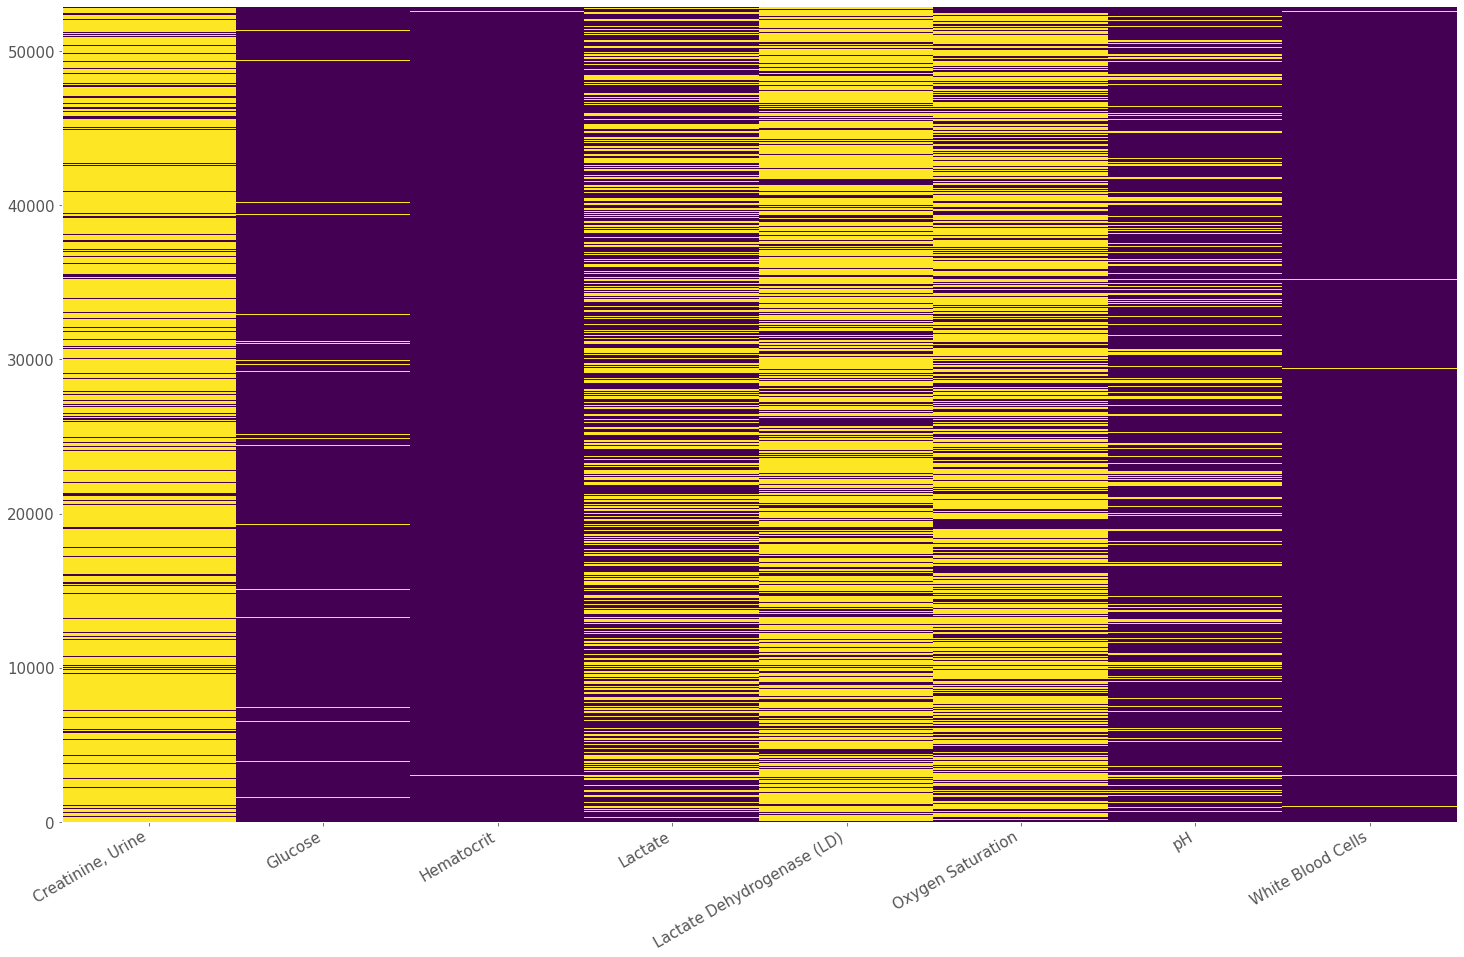

In [13]:
# DISPLAY COLORMAP OF MISSING SAMPLES FOR EACH VARIABLE
# REFERRING TO THIS AS AN AFFINITY MAP, SHOWING WHICH DATA WAS COLLECTED MOST OFTEN TOGETHER. 
# ASSIGNING NaN A POSITIVE VALUE MAKES MISSING DATA APPEAR BRIGHT YELLOW

lab_count_map_df = lab_counts_df.copy()
lab_count_map_df.drop(['label'], axis=1, inplace=True)
for col in lab_count_map_df.columns:
        lab_count_map_df[col] = lab_count_map_df[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        

# lab_count_map_df = lab_count_map_df.sort_values(by ='Oxygen Saturation', axis = 0, ascending = True)
plt.rc('font', size=15)   
plt.figure(figsize= (25,15))
plt.pcolor(lab_count_map_df)
#ax.set_ylim([0.0,missing.shape[0]])


plt.xticks(np.arange(0.5, len(lab_count_map_df.columns), 1), lab_count_map_df.columns)
plt.xticks(rotation = 30, ha = 'right')

plt.show()
plt.close()

In [14]:
lab_events_data_df

,subject_id,icustay_id,gender,label,charttime,valuenum,flag,hospital_expire_flag
714216,55973,200001,F,Hematocrit,2181-11-25 16:16:00,26.10,abnormal,0
714217,55973,200001,F,White Blood Cells,2181-11-25 16:16:00,2.90,abnormal,0
714218,55973,200001,F,pH,2181-11-25 17:00:00,5.00,NaN,0
714219,55973,200001,F,Lactate,2181-11-25 19:27:00,1.40,NaN,0
714220,55973,200001,F,pH,2181-11-25 19:27:00,7.41,NaN,0
...,...,...,...,...,...,...,...,...
143815,7630,299999,M,Oxygen Saturation,2117-09-01 01:53:00,98.00,NaN,0
143816,7630,299999,M,pH,2117-09-01 01:53:00,7.38,NaN,0
143817,7630,299999,M,Hematocrit,2117-09-01 07:27:00,33.00,abnormal,0
143818,7630,299999,M,White Blood Cells,2117-09-01 07:27:00,15.90,abnormal,0


## Feature Engineering
Calculating values from original data including mean, std, delta etc. 


In [15]:
labels2

['Creatinine',
 'Creatinine, Urine',
 'Glucose',
 'Hematocrit',
 'Lactate',
 'Lactate Dehydrogenase (LD)',
 'Oxygen Saturation',
 'pH',
 'White Blood Cells']

In [16]:
# height and weight are left out from the calculated measures because there was only one
# measurement so they are constant.

# creates dicts of new feature names with the lab label as entries
# this will help in traversing columns and calculating new features

# labels2 were sorted alphabetically so we order this list accordingly before zipping
dict_names = ['Creat','CreatUrine', 'Gluc', 'Hemat', 'Lac', 'LacDehyd', 'O2sat', 'pH', 'WBC']

first_dict_names = dict(zip([item + '_first' for item in dict_names], labels2))
mean_dict_names = dict(zip([item + '_mean' for item in dict_names], labels2))
med_dict_names = dict(zip([item + '_med' for item in dict_names], labels2))
std_dict_names = dict(zip([item + '_std' for item in dict_names], labels2))
skew_dict_names = dict(zip([item + '_skew' for item in dict_names], labels2))
min_dict_names = dict(zip([item + '_min' for item in dict_names], labels2))
max_dict_names = dict(zip([item + '_max' for item in dict_names], labels2))
slope_dict_names = dict(zip([item + '_slope' for item in dict_names], labels2))
delta_dict_names = dict(zip([item + '_delta' for item in dict_names], labels2))
abnflag_dict_names = dict(zip([item + '_abnflag' for item in dict_names], labels2))

In [17]:
first_dict_names

{'Creat_first': 'Creatinine',
 'CreatUrine_first': 'Creatinine, Urine',
 'Gluc_first': 'Glucose',
 'Hemat_first': 'Hematocrit',
 'Lac_first': 'Lactate',
 'LacDehyd_first': 'Lactate Dehydrogenase (LD)',
 'O2sat_first': 'Oxygen Saturation',
 'pH_first': 'pH',
 'WBC_first': 'White Blood Cells'}

In [18]:
# creates list of name_dicts
names_list = [first_dict_names, mean_dict_names, med_dict_names, std_dict_names, skew_dict_names, 
              min_dict_names, max_dict_names, slope_dict_names, delta_dict_names, abnflag_dict_names ]
# create list of zipping into dictionary the measurement type and 
# corresponding names dict 
calc_list = ['first', 'mean', 'med', 'std', 'skew', 'min', 'max', 'slope', 'delta', 'abnflag']

# create dictionary where the key is the feature type (calculation
# and the value is the appropriate names dicts
names_dict = dict(zip(calc_list, names_list))


# CREATE DICTIONARIES IN WHICH TO STORE CALCULATED VALUES
first_dict = {}
mean_dict = {}
med_dict = {}
std_dict = {}
skew_dict = {}
kurt_dict = {}
min_dict = {}
max_dict = {}
slope_dict = {}
delta_dict = {}
abnflag_dict = {}
dict_list = [first_dict, mean_dict, med_dict, std_dict, skew_dict, min_dict, max_dict, slope_dict, delta_dict,
            abnflag_dict]
calc_dict = dict(zip(calc_list, dict_list))

In [19]:
calc_dict

{'first': {},
 'mean': {},
 'med': {},
 'std': {},
 'skew': {},
 'min': {},
 'max': {},
 'slope': {},
 'delta': {},
 'abnflag': {}}

In [20]:
# iterating through the lab measurements for each ICU stay, calculating means, medians, std, skewness min and max
# lab measurements within an ICU stay with too few measurements to calculate feature will be assigned NaN values

print("Creating data frames for each summary statistic for each time course variable")
for calc_key in calc_dict.keys():
    for col_key in names_dict[calc_key].keys(): 
        if calc_key == 'mean':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].mean())
        elif calc_key == 'med':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].median())
        elif calc_key == 'std':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].std())
        elif calc_key == 'max':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].max())
        elif calc_key == 'min':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].min())
        elif calc_key == 'first': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'skew':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].skew())
        elif calc_key == 'delta': 
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last() -
                                                        lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first())
        elif calc_key == 'abnflag':
            calc_dict[calc_key][col_key] = pd.DataFrame(lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['flag'].apply(lambda x: int(1) if 'abnormal' in x.values else int(0)))
              
        elif calc_key == 'slope':
            time_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].last()
            time_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['charttime'].first()
            val_last = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].last()
            val_first = lab_events_data_df[lab_events_data_df.label == names_dict[calc_key][col_key]].groupby('icustay_id')['valuenum'].first()
            calc_dict[calc_key][col_key] = pd.DataFrame((val_last - val_first)/((time_last - time_first)/np.timedelta64(1,'h')))           
        
            
        else: 
            print("need to add code for calculating {}".format(calc_key))
            break
            
        calc_dict[calc_key][col_key].replace([np.inf, -np.inf], np.nan, inplace = True)
        calc_dict[calc_key][col_key].columns = [col_key]
        calc_dict[calc_key][col_key]['hospital_expire_flag'] = lab_events_data_df.groupby('icustay_id').hospital_expire_flag.first()
        calc_dict[calc_key][col_key]['gender'] = lab_events_data_df.groupby('icustay_id').gender.first()

print("complete")

Creating data frames for each summary statistic for each time course variable
complete


## PLOTTING DATA

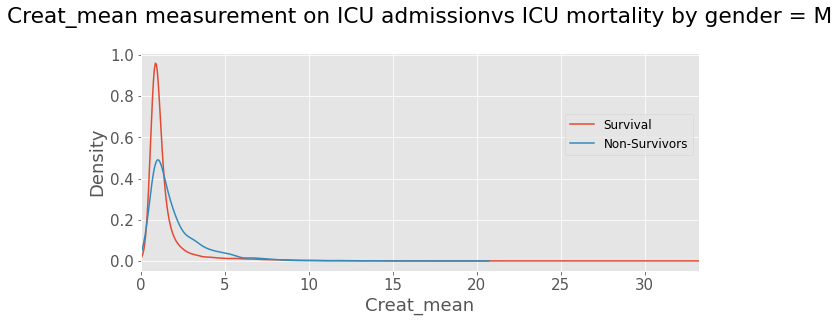

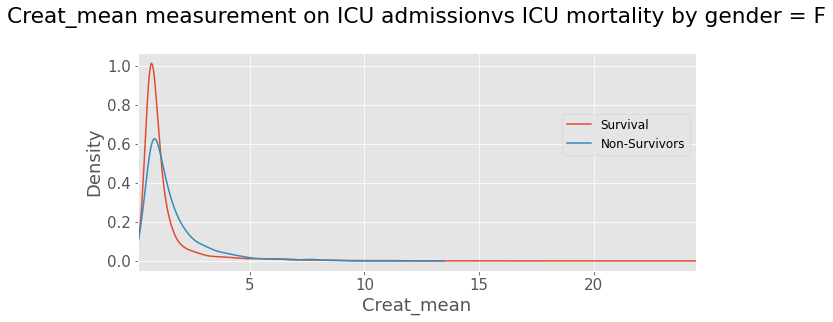

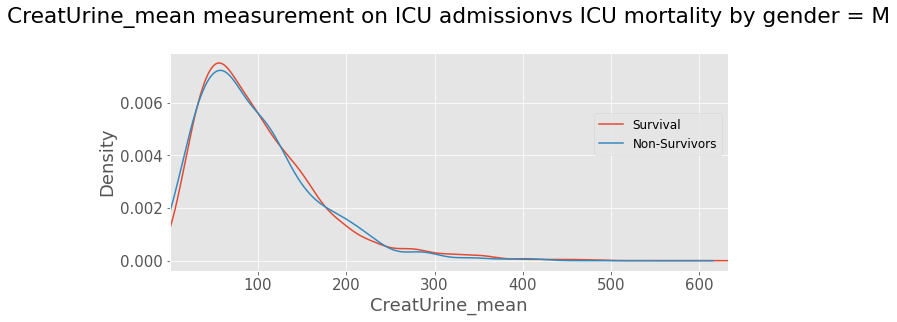

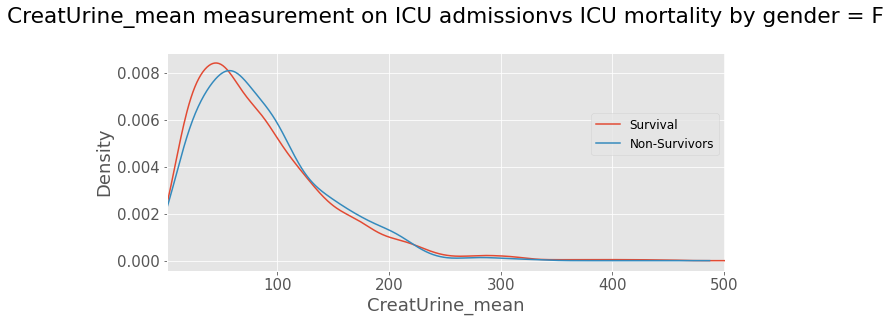

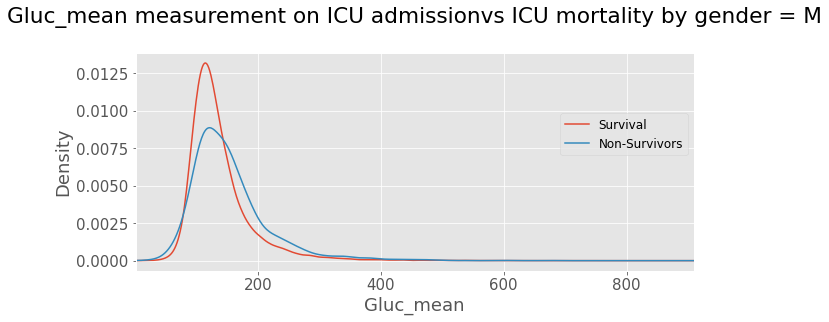

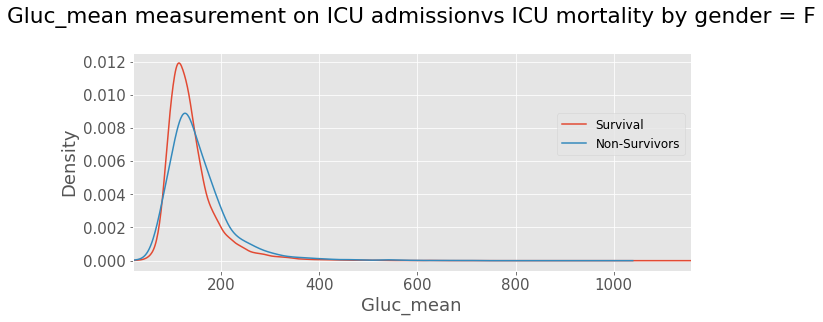

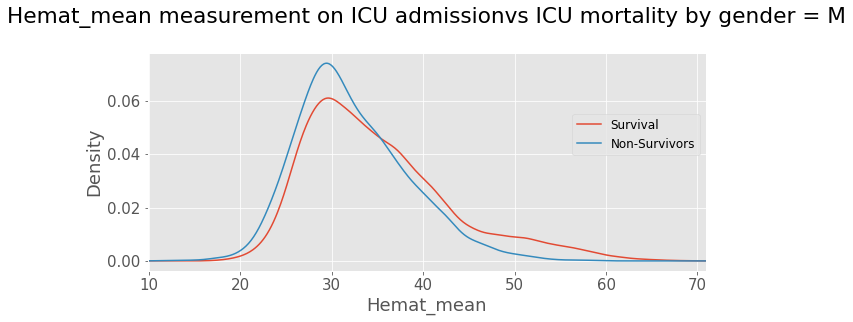

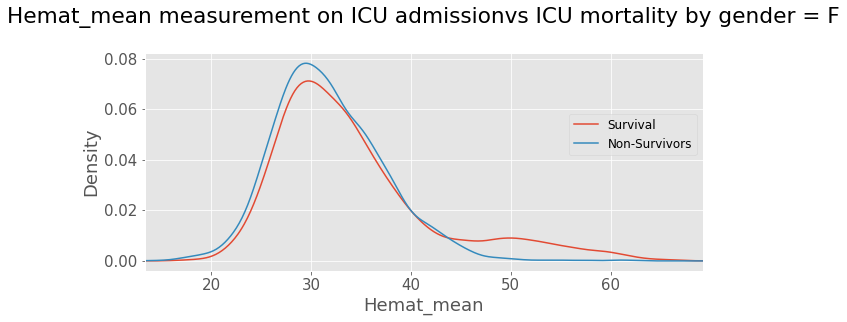

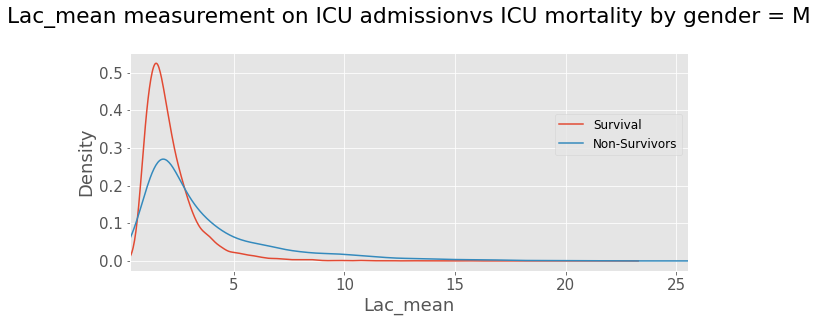

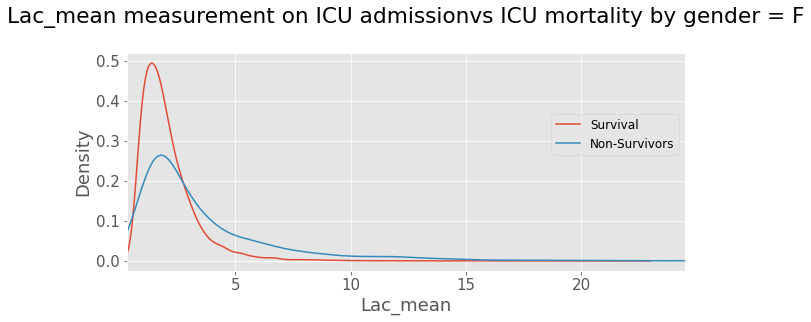

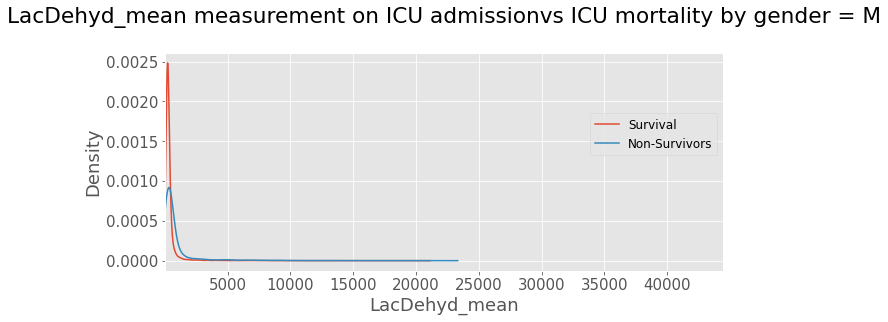

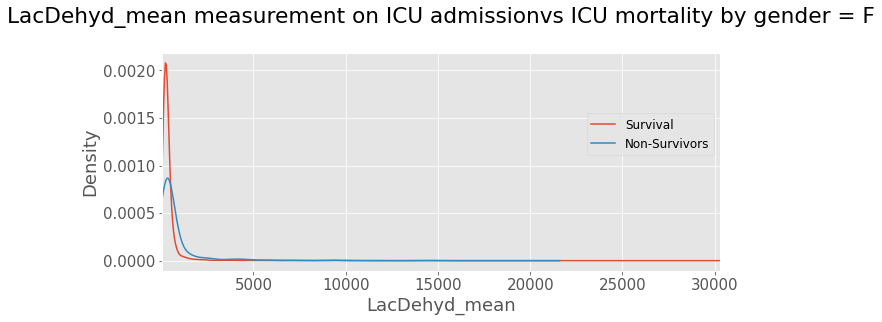

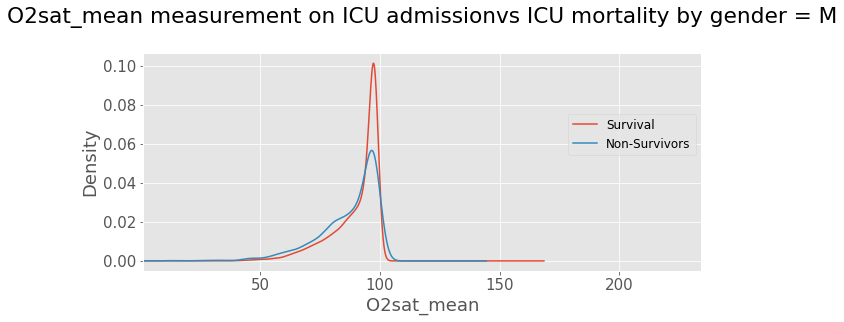

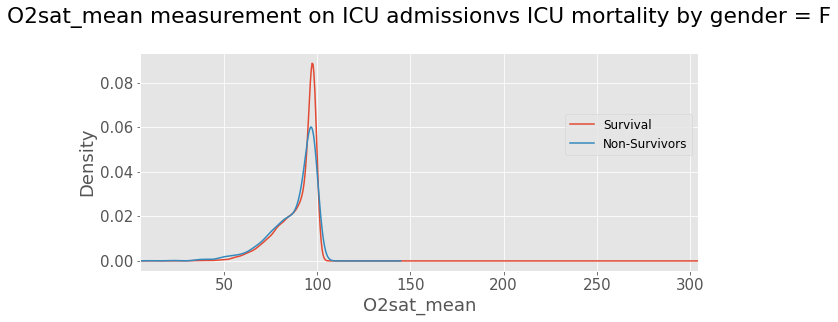

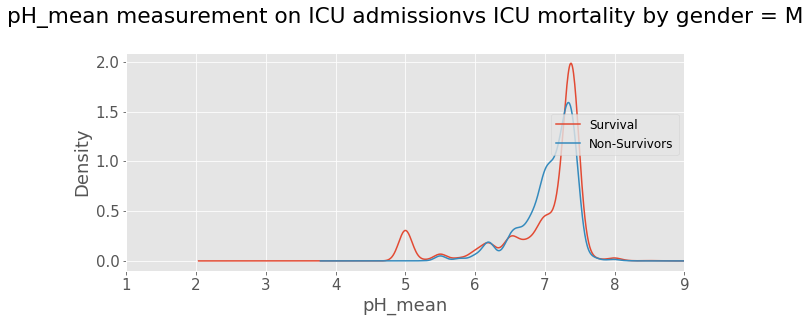

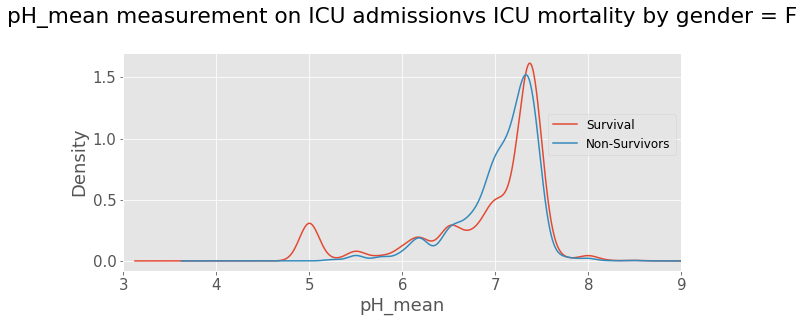

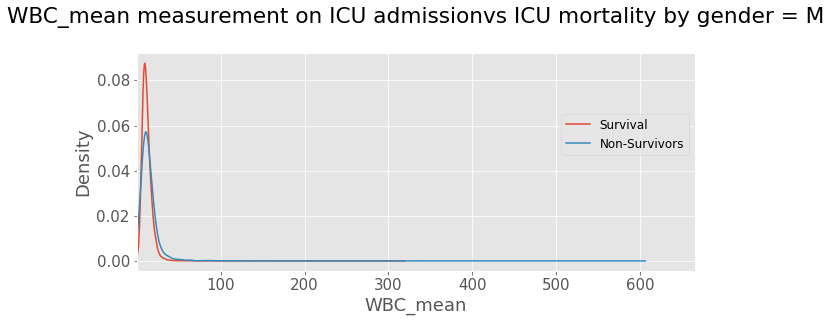

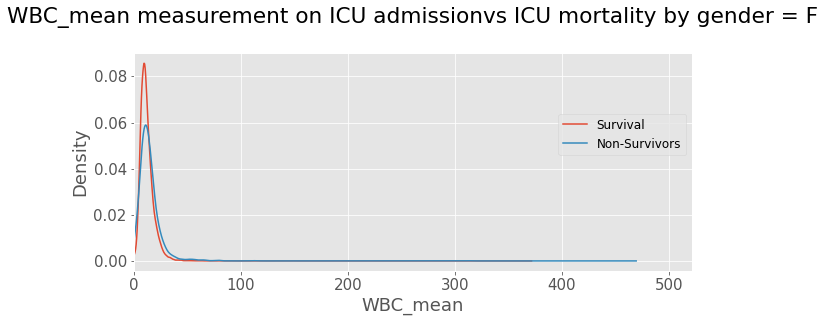

In [21]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['mean']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(.75,.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        plt.xlim(minlim, maxlim)

## REMOVE OUTLIER DATA POINTS 

In [ ]:
# 

names_dict = {}
suffix = '_outliers'

# SETTING OUTLIER DATA POINTS TO NAN FOR REMOVAL USING DROPNA()
for calc in calc_dict.keys():
    frame = calc_dict[calc]
    for col in frame.keys():
    # plot
    # print col
        dummy = frame[col]
        col2 = dummy.columns[0]
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)
        Q1 = np.percentile(dummy[col2].dropna(), 25)
        # TODO: Calculate Q3 (75th percentile of the data) for the given feature
        Q3 = np.percentile(dummy[col2].dropna(), 75)
        # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
        step = 1.5*(Q3 - Q1)
        names_dict[col+suffix] = dummy[~((dummy[col2] >= Q1 - step) & (dummy[col2] <= Q3 + step))].index
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
#         dummy.set_value(names_dict[col+suffix], col2, np.NaN)
        dummy.loc[names_dict[col+suffix], col2] = np.NaN
        #print "{}   {}     {}".format(col, col2, dummy.dropna().shape)




In [ ]:
names_dict[col+suffix]

In [ ]:
dummy

## PLOT DATA WITH OUTLIERS REMOVED

In [ ]:
# PLOTTING DATA FOR EXAMPLE FRAME
#mean_dict[mean_dict.keys()[0]].head()
dummy = calc_dict['min']

for col in dummy.keys():
    
    col2 = dummy[col].columns[0]
    
    
    gender = ['M', 'F'] 
    
    for gend in gender:
        
        #print gend
        dead = dummy[col][(dummy[col].hospital_expire_flag == 1)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        dead.name = 'Non_Survivors'
        live = dummy[col][(dummy[col].hospital_expire_flag == 0)&
                              (dummy[col].gender == gend)]
                          #&(const_dict[col][col2] >20)]
        live.name = 'Survivors'
    
    
    
    
    #dummy = mean_dict[key][mean_dict[key].gender == 'F']
    #dummy = skew_dict[key].merge(pd.DataFrame(ptnt_demog['hospital_expire_flag']), 
    #                                   left_index = True, right_index = True, how='left', sort = True)
    
        maxx = 0.99
        minn = 0.01
    
        live_max = live[col2].dropna().max()#quantile(0.999)
        live_min = live[col2].dropna().min()#quantile(0.001)
        dead_max = dead[col2].dropna().max()#quantile(0.999)
        dead_min = dead[col2].dropna().min()#quantile(0.001)
        maxlim = max(live_max, dead_max)
        minlim = min(live_min, dead_min)
   
        
        plt.subplots(figsize=(10,4))
        live[(live[col2] < live_max) & (live[col2] > live_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Survival')
    
        dead[(dead[col2] < dead_max) & (dead[col2] > dead_min)][col2].plot.kde(
                                                                            alpha=1.0,label='Non-Survivors')
        # add title, labels etc.
        plt.title('{} measurement on ICU admission'.format(col) + 
                   'vs ICU mortality by gender = {}\n'.format(gend))
        plt.xlabel(col)
        plt.legend(loc="upper left", bbox_to_anchor=(0.75,0.75),fontsize=12)
   
    
        #print "{}    {}".format(maxlim, minlim)
        #plt.xlim(minlim, maxlim)

## MERGE INDIVIDUAL DATAFRAMES INTO SINGLE FRAME

In [ ]:
# MERGING INDIVIDUAL CALCULATED FRAMES INTO A SINGLE DATAFRAMEs
lab_events_data_df2 = lab_events_data_df.drop_duplicates('icustay_id', keep = 'first')
lab_events_data_df3 = lab_events_data_df2.drop(['label', 'charttime', 'valuenum', 'flag'], axis = 1)
lab_events_data_df3.set_index(['icustay_id'], inplace = True)

for calc_key in calc_dict.keys():
    print("merging {} dataframe".format(calc_key))
    for col_key in calc_dict[calc_key].keys(): 
        col2 = calc_dict[calc_key][col_key]
        lab_events_data_df3 = lab_events_data_df3.merge(pd.DataFrame(calc_dict[calc_key][col_key][col_key]), left_index = True, 
                           right_index = True, how = 'left', sort = True)
        newcols = list(lab_events_data_df3.columns)
        newcols.pop()
        newcols.append(col_key)
        lab_events_data_df3.columns = newcols
display(lab_events_data_df3.shape)
display(lab_events_data_df3.head())
display(lab_events_data_df3.dtypes)
        
# OLD CODE


In [ ]:
lab_events_data_df3.columns

In [ ]:
calc

In [ ]:
[x for x in lab_events_data_df3.columns if calc in x] 

In [ ]:
lab_events_data_df3.columns

In [ ]:
boolean_cols = [
    
    
]

In [ ]:
lab_events_data_df3['Creat_abnflag'].head(25).fillna(0).astype(int)

In [ ]:
lab_events_data_df3['Creat_abnflag'].head(25).apply(lambda x: 1 if x==1.0 else 0)

# Convert Boolean Cols to INT

In [ ]:
cols = [x for x in lab_events_data_df3.columns if calc in x]
for col in cols: 
    lab_events_data_df3[col] = lab_events_data_df3[col].fillna(0).astype(int)

# Prior Versions Didn't Fully Leverage Interpolation
As Such, efforts below were made to found labs most commonly found together. 

## Looking for labs that are commonly missing together

In [ ]:
# # ROUNDING DATA
# np.set_printoptions(precision=2)

# cols = [x for x in lab_events_data_df3.columns if calc in x] 
# cols.sort()
    
# header = lab_events_data_df3[cols]
# for col in header.columns:
#     header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
# display(lab_events_data_df3[cols].dropna().shape[0])

# display(header.corr().round(2))

## DISPLAY COLORMAP OF MISSING DATA

In [ ]:
# commenting out for refinement. 
# very time consuming part of pre-processing. uncomment and run if you'd like to see the process. 


'''
# DISPLAY COLORMAP OF DATA 

for calc in calc_list:
    plt.figure(figsize= (30,30))
    cols = [x for x in data3.columns if calc in x] 
    cols.sort()
    
    header = data3[cols]
    for col in header.columns:
        max_val = -1000 #header[col].max()*100
        #header[col].replace(np.nan, max_val, inplace = True)
        header[col] = header[col].apply(lambda x: 1 if pd.isnull(x) else 0)
    display(data3[cols].dropna().shape[0])
    missing = header.corr()
    display(missing[missing >= 0.4])
    plt.pcolor(header)
    plt.xticks(np.arange(0.5, len(header.columns), 1), header.columns)
    plt.show()

print "Complete"
'''

## CREATE AUTOCORRELATION MATRIX FOR MISSING DATA

In [ ]:
# #header.apply(lambda col: col.autocorr(lag = 1), axis = 0)
# # REPLACING NAN VALUES WITH 1 AND MEASUREMENTS WITH 0. PERFORMING CORRELATION BETWEEN COLUMNS TO DETERMINE WHICH 
# # VARIABLES ARE MOST LIKELY TO BE MISSING TOGETHER. THIS WILL HELP IN BLOCKING DATA FOR PROCESSES THAT REQUIRE DATA TO 
# # BE NAN FREE
# missing = lab_events_data_df3.copy()
# for col in missing.columns:
#     missing[col] = missing[col].apply(lambda x: 1 if pd.isnull(x) else 0)
        
# monkey = missing.corr()
# monkey[monkey >= 0.4]

In [ ]:
# DROPPING COLUMNS WHERE DATA IS SPARSE AND MISSING DATA DOES NOT CORRELATE WITH OTHER VARIABLES. 
# THESE DETERMINATIONS WERE MADE THROUGH OBSERVATIONS OF THE AFFINITY MAPS AND DROPNA().SHAPE[0] VALUES ABOVE 

# REMOVING ALL CREATURINE MEASURES
drop_cols = []
for item in lab_events_data_df3.columns: 
    if (('CreatUrine'in item) | ('LacDehyd' in item) | ('_skew' in item)):
        drop_cols.append(item)
#drop_cols

# DROP THE FOLLOWING MEASURES OF THE FOLLOWING VARIABLES
#drop_names = ['CreatUrine', 'LacDehyd', 'O2sat', 'Lac']
drop_names = ['O2sat', 'Lac']
drop_measures = ['_std', '_slope']
for name in drop_names:
    for ext in drop_measures:
        drop_cols.append(name + ext)
        
drop_cols
        

display(lab_events_data_df3.dropna().shape[0])
lab_events_data_df4 = lab_events_data_df3.drop(drop_cols, inplace = False, axis = 1)
display(lab_events_data_df4.dropna().shape[0])

print("Complete")

## COMBINING FRAMES AND DROPPING MISSING VALUES

In [ ]:
# # TO THIS POINT THE ICUSTAY_ID HAS BEEN USED AS THE INDEX OF THE DATAFRAME. 
# # TO USE THESE METHODS WE CREATE A PROPER INDEX


# # BREAKING UP VARIABLES SO THAT WE CAN DROP NAN VALUES AND STILL HAVE SUFFICIENT SAMPLES 
# # TO TRANSFORM AND DO FEATURE SELECTION / SCORING
# # WILL NEED TO MERGE LATER IN A WAY THAT PROVIDES ADEQUATE SAMPLES

# cols1 = [x for x in data4.columns if (('abnflag' not in x) & (('pH' in x) | ('Lac' in x) | ('O2sat' in x)))]
# cols2 = [x for x in data4.columns if (('abnflag' not in x) & (('Creat' in x) | ('Gluc' in x) | ('Hemat' in x) | ('WBC' in x)))]
# cols3 = [x for x in data4.columns if ('abnflag' in x)]

# header = ['hospital_expire_flag']
# for thing in header:
#     cols1.insert(0, thing)
#     cols2.insert(0, thing) 
#     cols3.insert(0, thing)
  

# #display(cols1)
# data4.replace([np.inf, -np.inf], np.nan, inplace = True)
# pHLacO2Sat_data = data4[cols1].dropna()
# print "pHLacO2Sat_data: Shape = "
# display(pHLacO2Sat_data.shape)                              

# CreatGlucHemWBC_data = data4[cols2].dropna()
# print "CreatGlucHemWBC_data: Shape = "
# display(CreatGlucHemWBC_data.shape)

# AbnFlag_data = data4[cols3].dropna()
# print "AbnFlag_data: Shape = "
# display(AbnFlag_data.shape)

       
# cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
# cat_frames = [AbnFlag_data]




In [ ]:
lab_events_data_df4.replace([np.inf, -np.inf], np.nan, inplace = True)

In [ ]:
lab_events_data_df4.columns

In [ ]:
X = lab_events_data_df4[lab_events_data_df4.columns[3:]]
# imp_iter = IterativeImputer(missing_values = np.nan, max_iter=100, add_indicator=True)
imp_iter = SimpleImputer(missing_values = np.nan, add_indicator=False)
imp_iter.fit(X)
imputed_data_df = imp_iter.transform(X)


In [ ]:
imputed_data_df.shape

In [ ]:
lab_events_data_df4[lab_events_data_df4.columns[3:]] = imputed_data_df


## CONVERTING CONTINUOUS TO CATEGORICAL VARIABLES

In [ ]:
lab_events_data_df4.columns

In [ ]:
# CALCULATING THE QUARTILES ON THE DISTRIBUTIONS AND BINNING DATA INTO 4 BUCKETS
# TO CONVERT CONTINUOUS VARIABLES TO CATEGORICAL

def quant_cats(feature, Q1, Q2, Q3):
    if feature <=Q1:
        return 'Q0'
    elif (feature >Q1 and feature <= Q2):
        return 'Q1'
    elif (feature > Q2 and feature <= Q3):
        return 'Q2'
    elif feature > Q3:
        return 'Q3'
    
#cont_frames = [pHLacO2Sat_data, CreatGlucHemWBC_data]
#cat_frames = [AbnFlag_data]
    
CreatGlucHemWBC_cat_data = CreatGlucHemWBC_data.copy()
pHLacO2Sat_cat_data = pHLacO2Sat_data.copy()

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]

for frame in cont_cat_frames:
    frame_stats = frame.describe()
    for col in frame.columns[1:]:
        Q1 = frame_stats[col].loc['25%']
        Q2 = frame_stats[col].loc['50%']
        Q3 = frame_stats[col].loc['75%']
        frame[col] = frame[col].apply(lambda x: quant_cats(x, Q1, Q2, Q3))

pHLacO2Sat_cat_data.head()        




## COMBINING FRAMES

In [ ]:

cont_cat_frames = [CreatGlucHemWBC_cat_data, pHLacO2Sat_cat_data]


pHLacO2Sat_dummies = pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[:1]].merge(pd.get_dummies(pHLacO2Sat_cat_data[pHLacO2Sat_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
CreatGlucHemWBC_dummies = CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[:1]].merge(pd.get_dummies(CreatGlucHemWBC_cat_data[CreatGlucHemWBC_cat_data.columns[3:]]), left_index = True, right_index = True, 
                       how = 'left', sort = True)
                       
display(pHLacO2Sat_dummies.head())
display(CreatGlucHemWBC_dummies.head())


## CONVERT DATA TO DUMMY VARIABLES, RECOMBINE, SELECT BEST FEATURES WRITE TO FILE

In [ ]:
dummy_frames = [CreatGlucHemWBC_dummies, pHLacO2Sat_dummies, AbnFlag_data]
dummy_frame_filenames = ['Lab_CreatGlucHemWBC_Features', 'Lab_pHLacO2Sat_Features', 'Lab_AbnFlag_Features']
dummy_dict = dict(zip(dummy_frame_filenames, dummy_frames))

for name, frame in dummy_dict.iteritems():
    print "{}      {}".format(name, frame.shape[0])

# CREATGLUC ETC HAS ONLY 874 SAMPLES AND SO WON'T BE HELPFUL. 

root = os.getcwd() + '/features/'

for name, frame in dummy_dict.iteritems():#frame = cat_dummy_frames[0]
    X_continuous = frame[frame.columns[1:]]
    y = frame['hospital_expire_flag']
    #display(X_continuous.shape)
    #display(y.shape)
    # ONLY PASSING FRAMES W/ > 5000 ICUSTAYS
    if y.shape[0] > 3000:
        
        # SELECT K BEST FEATURES BASED ON CHI2 SCORES
        selector = SelectKBest(score_func = chi2, k = 'all')
        selector.fit(X_continuous, y)
        p_vals = pd.Series(selector.pvalues_, name = 'p_values', index = X_continuous.columns)
        scores = pd.Series(selector.scores_, name = 'scores', index = X_continuous.columns)
        cont_features_df = pd.concat([p_vals, scores], axis = 1)
        cont_features_df.sort_values(by ='scores', ascending = False, inplace = True)
        best_features = frame[cont_features_df[cont_features_df.p_values < .001].index]
        frame = pd.DataFrame(y).merge(best_features, left_index = True, right_index = True, 
                       how = 'left', sort = True)
        print "{}     {}".format(name, frame.shape)
        frame.to_csv(root + name + '.csv')
        cont_features_df[cont_features_df.p_values < .001].to_csv(root + name + 'Scores.csv')